In [6]:
import seaborn as sns
from adaptive_CI.compute import collect
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
from time import time
from glob import glob
import scipy.stats as stats
from IPython.display import display, HTML
from adaptive_CI.saving import *
import  pickle
import warnings
from pickle import UnpicklingError
import copy
from itertools import compress
import scipy.stats as stats
from plot_utils import *

sns.set_context("notebook", font_scale=1.4)

%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Load data

In [125]:
commit = "442b70"

In [126]:
stats_files = glob(f"results/stats*{commit}*.pkl")
print(f"Found {len(stats_files)} files associated with statistics.")

dfs = []
for k, file in enumerate(stats_files):
    if k % 200 == 0:
        print(f"Reading file {k}.")
    try:
        dfs.append(pd.read_pickle(file))
    except Exception as e:
        print(f"Error when reading file {file}.")
        
print(f"Loaded {len(dfs)} files.")
df = pd.concat(dfs)
df['value'] = df['value'].astype(float)
decay_rates = np.sort(df['floor_decay'].unique())
df.shape

Found 499 files associated with statistics.
Reading file 0.
Reading file 200.
Reading file 400.
Loaded 499 files.


(3353280, 12)

In [9]:
lambda_files = glob(f"results/lambdas*{commit}*.pkl")
print(f"Found {len(lambda_files)} files associated with lambda values.")

dfs = []
for k, file in enumerate(lambda_files[:100]):
    if k % 5 == 0:
        print(f"Reading file {k}.")
    try:
        dfs.append(pd.read_pickle(file))
    except Exception as e:
        print(f"Error when reading file {file}.")
        
print(f"Loaded {len(dfs)} files.")
df_lambdas = pd.concat(dfs)
df_lambdas['value'] = df_lambdas['value'].astype(float)
df_lambdas['time'] = df_lambdas['time'].astype(float)
df_lambdas.shape

Found 1406 files associated with lambda values.
Reading file 0.
Reading file 5.
Reading file 10.
Reading file 15.
Reading file 20.
Reading file 25.
Reading file 30.
Reading file 35.
Reading file 40.
Reading file 45.
Reading file 50.
Reading file 55.
Reading file 60.
Reading file 65.
Reading file 70.
Reading file 75.
Reading file 80.
Reading file 85.
Reading file 90.
Reading file 95.
Loaded 100 files.


(5205000, 11)

----

In [1]:
data_lambda = pd.read_pickle('results/lambda_results.pkl')

# Figures in the paper

In [37]:
alpha = 0.7

### Plot arm values

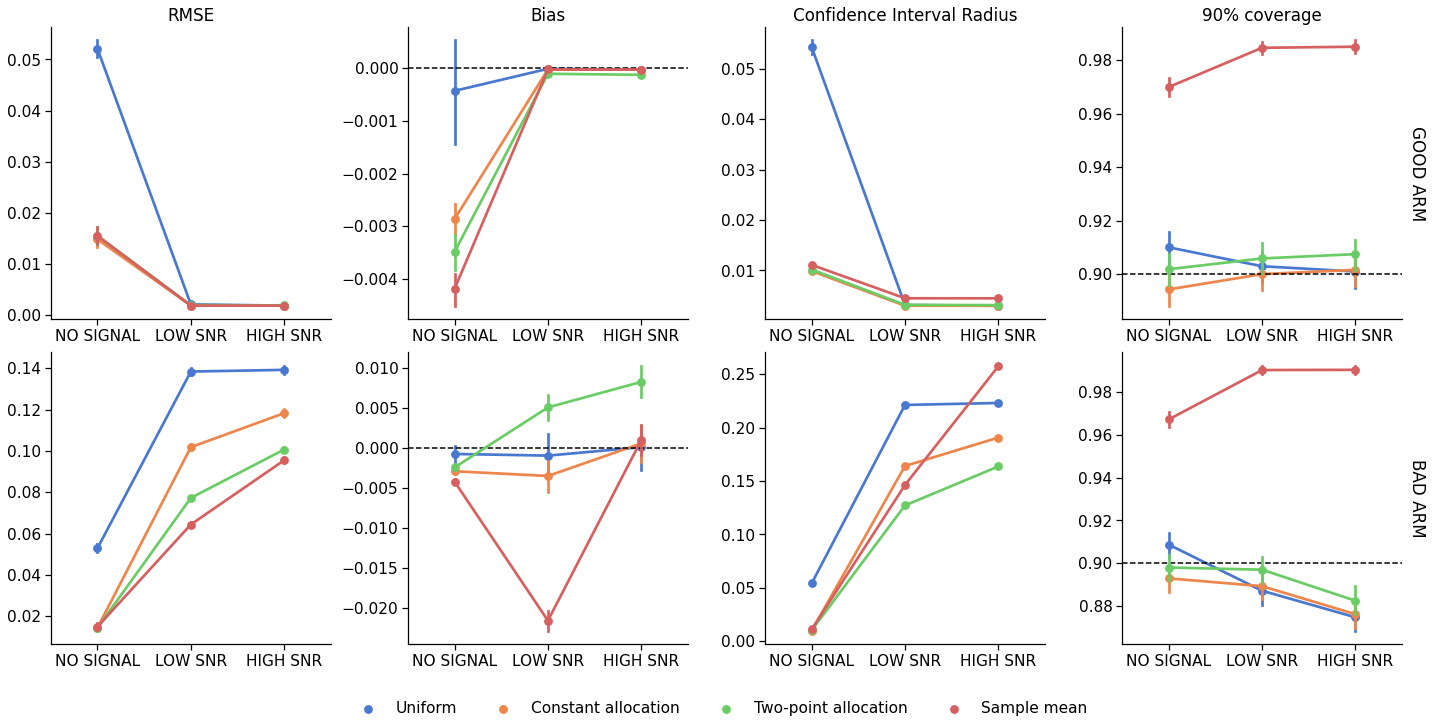

In [13]:
Ts = [1_000, 5_000, 10_000, 50_000, 100_000]
policies = ['(0,2)']
row_order=['nosignal', 'lowSNR', 'highSNR']
col_order=['mse', 'bias', 'CI_width', '90% coverage of t-stat']
col_names=['RMSE', 'Bias', 'Confidence Interval Radius', '90% coverage']
labels=['Unweighted AIPW', 'Constant allocation rate', 'Two-point allocation rate', 'Sample mean (normal CI)', 'Sample mean (Howard et al CI)']
hue_order=['uniform', 'lvdl', 'two_point',  'sample_mean_naive', 'gamma_exponential']
sns_palette = sns.color_palette('colorblind')
palette = [sns_palette[0], sns_palette[1], sns_palette[2], sns_palette[3], sns_palette[3]]

### Plot contrasts

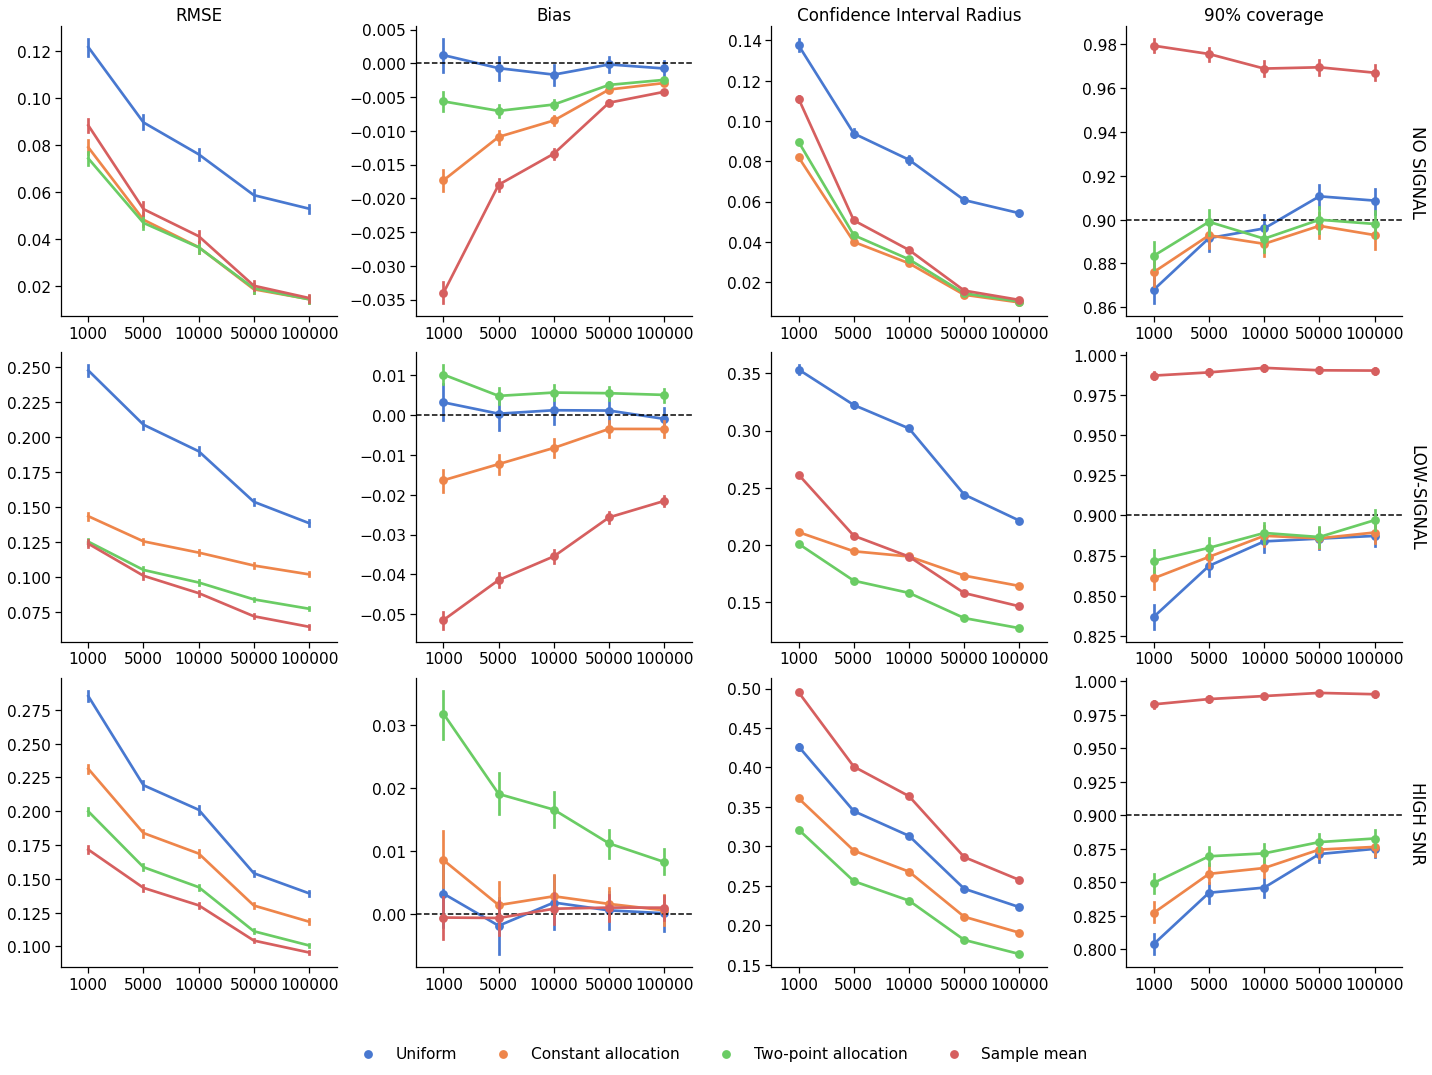

In [38]:
plot_contrast(df.query(f"policy==0 and floor_decay=={alpha}"),
              hue_order=['uniform',  'lvdl', 'two_point', 'bernstein'], 
              col_names=['RMSE', 'Bias', 'Confidence Interval Radius', '90% coverage'],
              labels=['Uniform', 'Constant allocation', 'Two-point allocation', 'Sample mean'],
              name="evoluation_arm_values0")

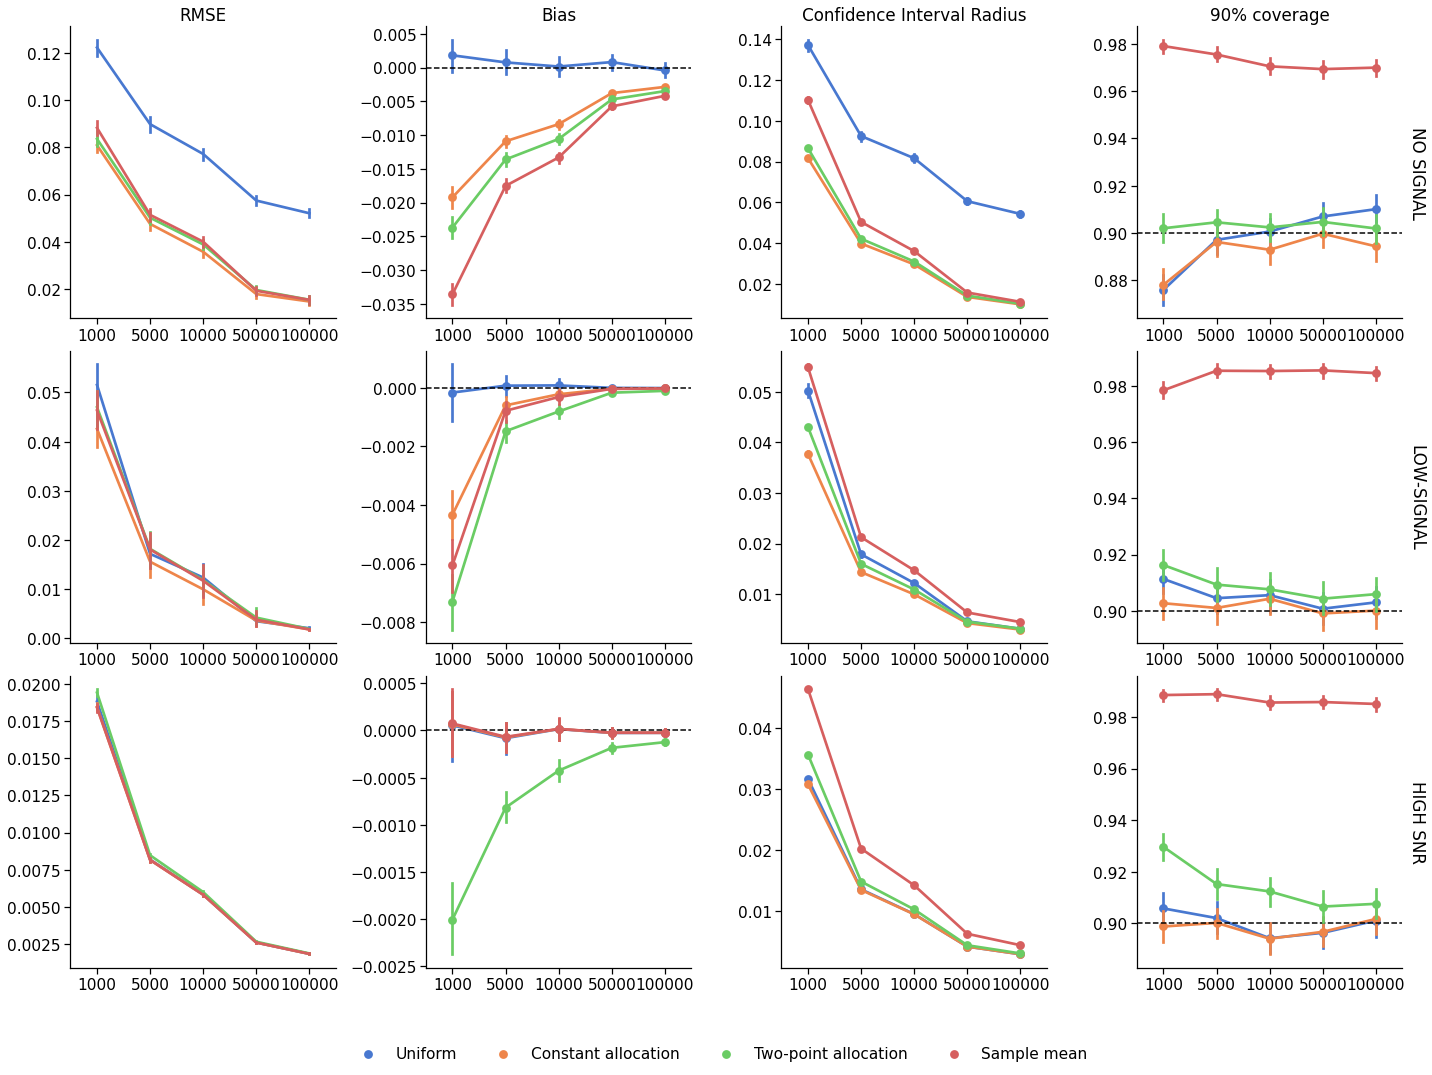

In [39]:
plot_contrast(df.query(f"policy==2 and floor_decay=={alpha}"),
              hue_order=['uniform',  'lvdl', 'two_point', 'bernstein'], 
              col_names=['RMSE', 'Bias', 'Confidence Interval Radius', '90% coverage'],
              labels=['Uniform', 'Constant allocation', 'Two-point allocation', 'Sample mean'],
              name="evoluation_arm_values2")

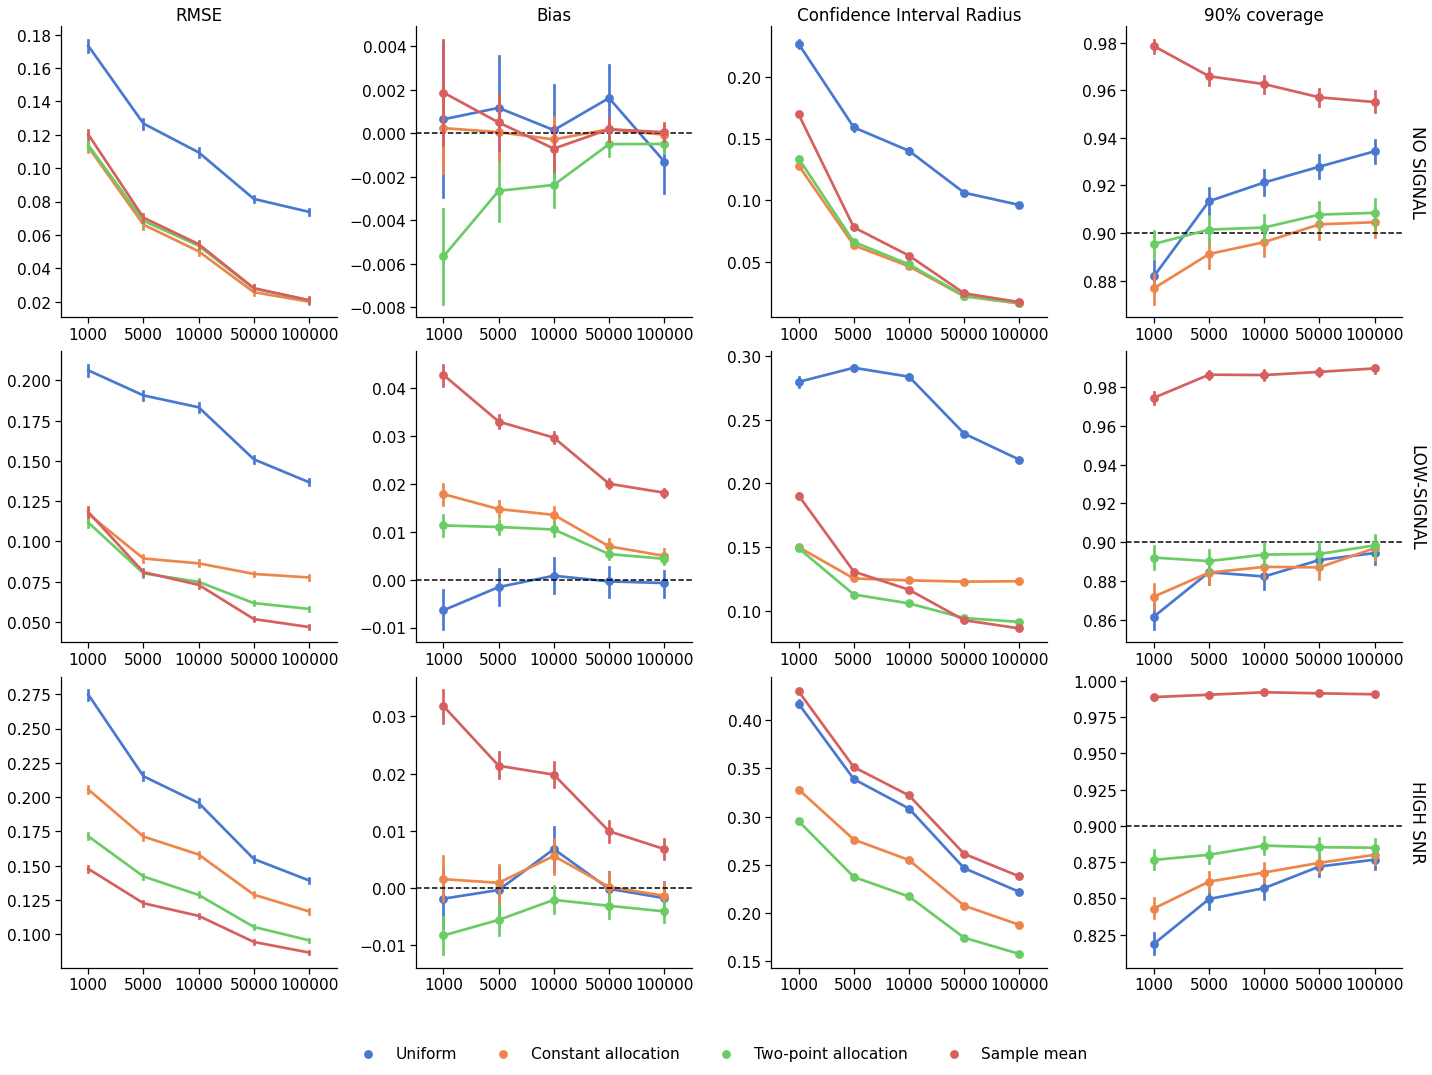

In [14]:
plot_contrast(df.query(f"policy=='(0,2)' and floor_decay=={alpha}"),
              hue_order=['uniform',  'lvdl', 'two_point', 'bernstein'], 
              col_names=['RMSE', 'Bias', 'Confidence Interval Radius', '90% coverage'],
              labels=['Uniform', 'Constant allocation', 'Two-point allocation', 'Sample mean'],
              name="contrast")

### Plot values $(T-t)\lambda_t$ under two-point allocation specification

In [31]:
plot_lambda(df_lambdas.query(f"T == 100_000 and floor_decay == {alpha}"))

### Plot comparison with W-decorrelation

In [30]:
plot_wdecorr_comparison(df.query(f"floor_decay == {alpha}"))

### Plot histograms

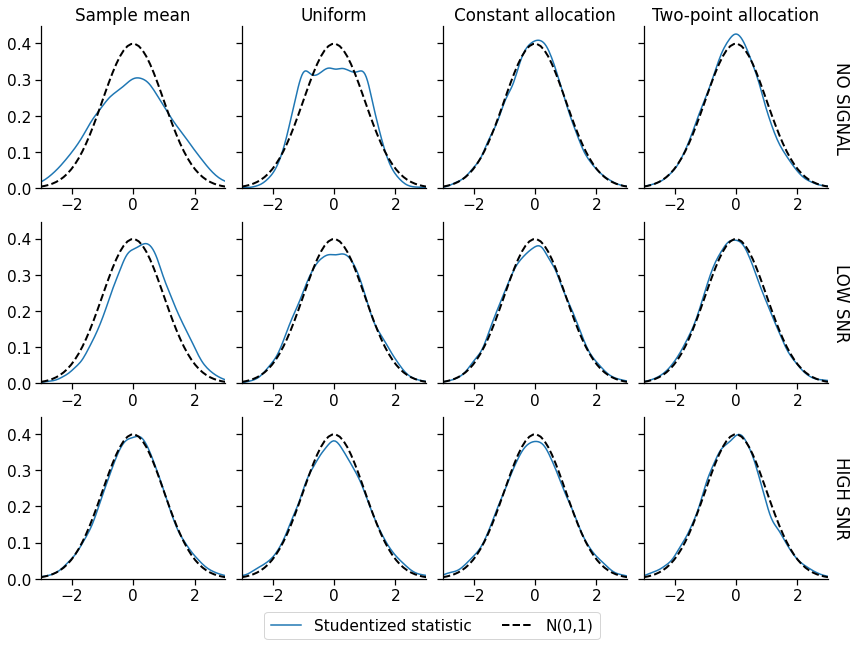

In [33]:
plot_hist(df.query("T == 100_000 and floor_decay == 0.7 and policy == '(0,2)'"), name="histogram")

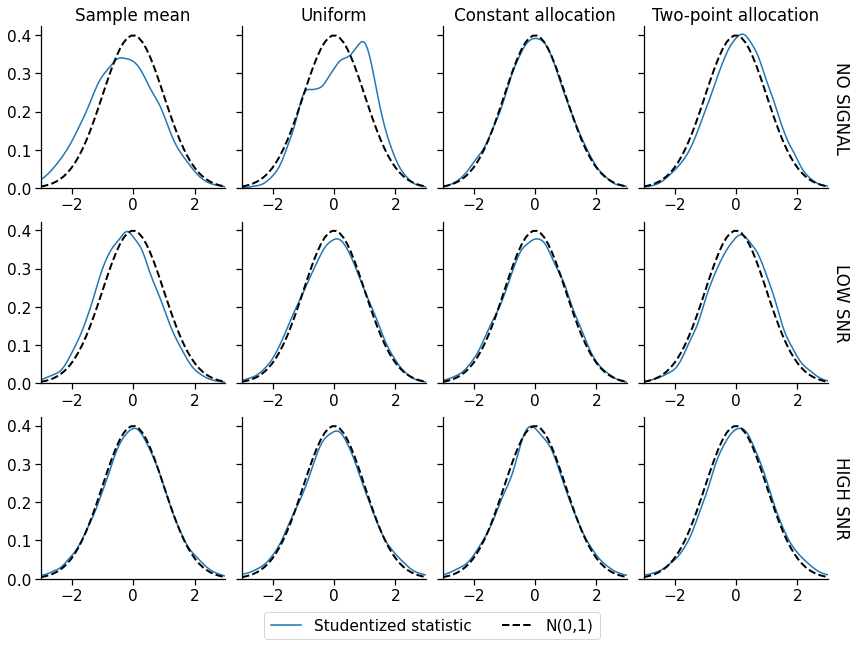

In [34]:
plot_hist(df.query("T == 100_000 and floor_decay == 0.7 and policy == 0"), name="histogram0")

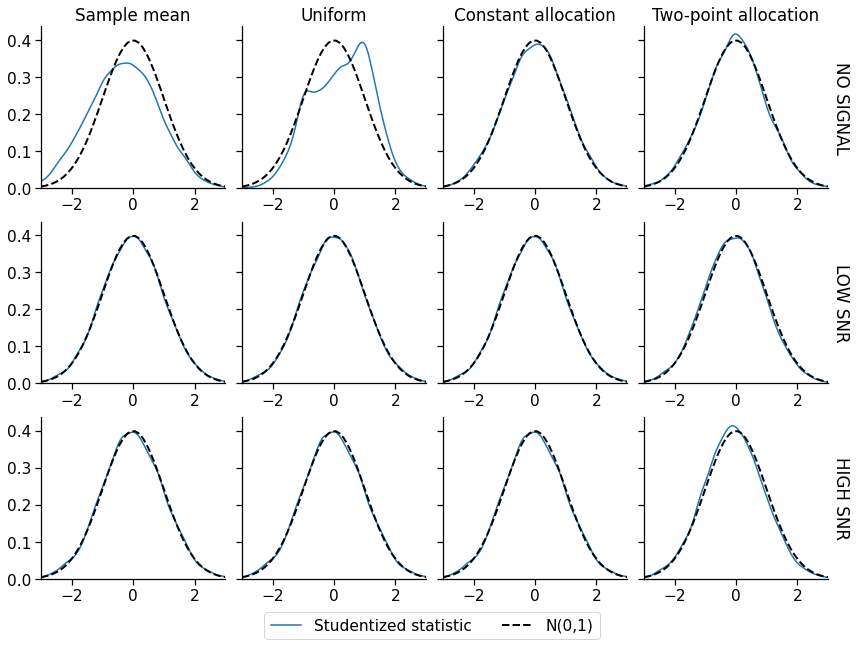

In [35]:
plot_hist(df.query("T == 100_000 and floor_decay == 0.7 and policy == 2"), name="histogram2")

## Other plots

### Plot arm values at large T

In [127]:
alpha = .7

Text(0.5, 1.0, 'Beta-bernoulli')

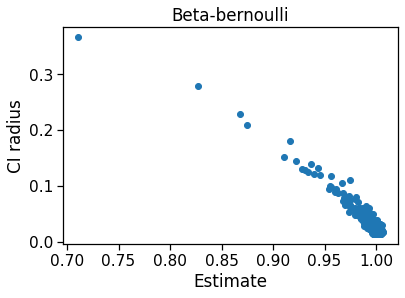

In [128]:
estimate = df.query(f"T == 100_000 and floor_decay=={alpha} and method == 'beta_bernoulli' and statistic == 'estimate' and policy == 0 and dgp == 'nosignal'")['value'].values
ci_radius = df.query(f"T == 100_000 and floor_decay=={alpha} and method == 'beta_bernoulli' and statistic == 'CI_width' and policy == 0 and dgp == 'nosignal'")['value'].values
plt.scatter(estimate, ci_radius)
plt.xlabel("Estimate")
plt.ylabel("CI radius")
plt.title("Beta-bernoulli")

In [134]:
from scipy.stats import pearsonr

In [135]:
pearsonr(estimate, ci_radius)

(-0.9591988831310551, 0.0)

Text(0.5, 1.0, 'Uniform')

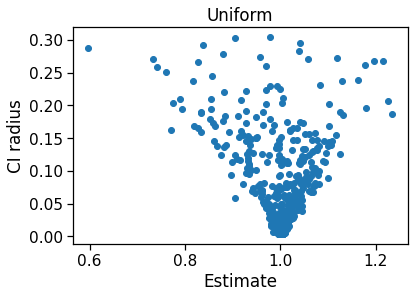

In [129]:
estimate_u = df.query(f"T == 100_000 and floor_decay=={alpha} and method == 'uniform' and statistic == 'estimate' and policy == 0 and dgp == 'nosignal'")['value'].values
ci_radius_u = df.query(f"T == 100_000 and floor_decay=={alpha} and method == 'uniform' and statistic == 'CI_width' and policy == 0 and dgp == 'nosignal'")['value'].values
plt.scatter(estimate_u, ci_radius_u)
plt.xlabel("Estimate")
plt.ylabel("CI radius")
plt.title("Uniform")

In [139]:
pearsonr(estimate_u, np.abs(ci_radius_u))

(-0.18759696967080336, 7.478641364891688e-07)

In [130]:
np.mean((estimate_u - ci_radius_u < 1) & (estimate_u + ci_radius_u > 1))

0.9198250728862973

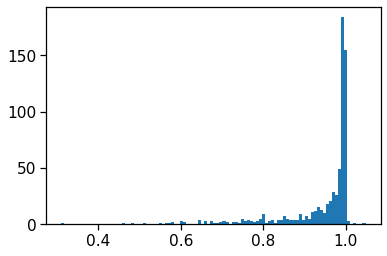

In [131]:
plt.hist(estimate_u - ci_radius_u, 100);

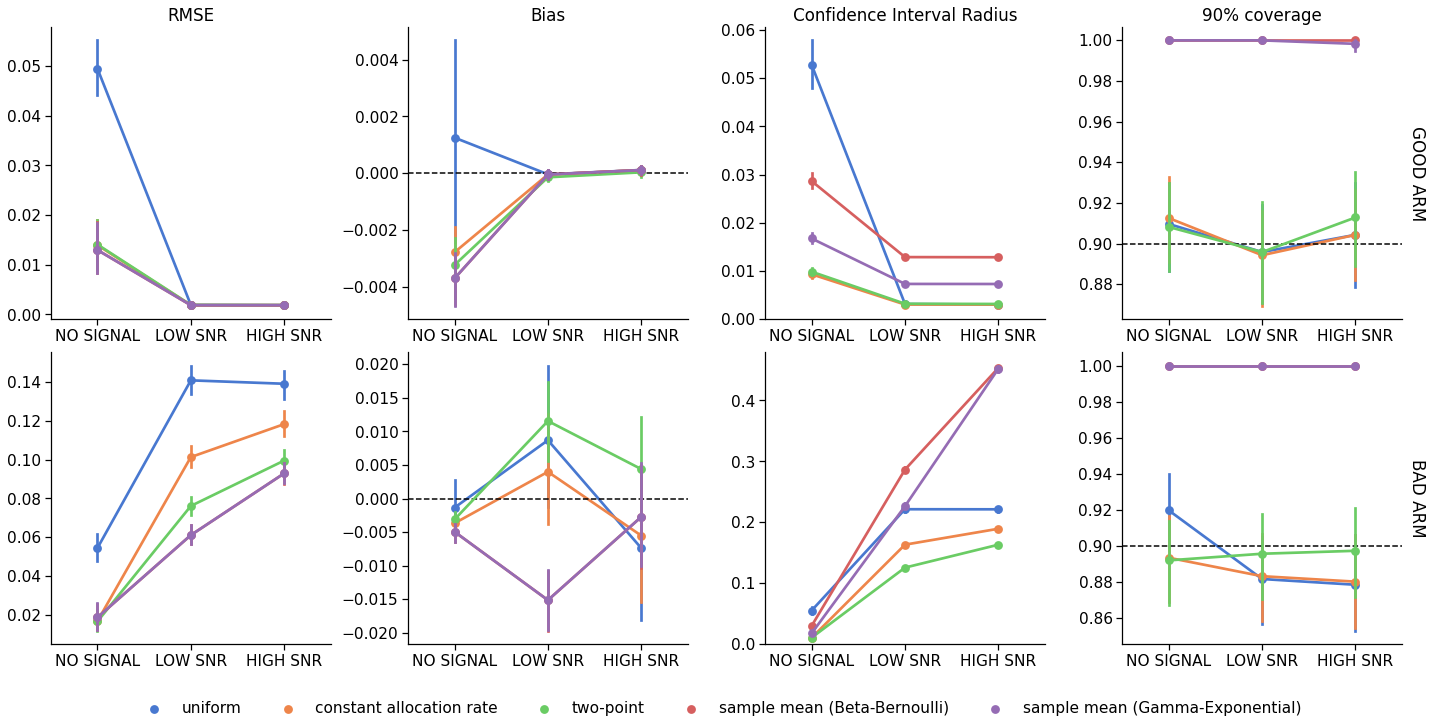

In [132]:
for alpha in decay_rates:
    display(HTML(f"<h2>Decay rate (alpha) = {alpha}</h2>"))
    plot_arm_values(
        df=df[(df['floor_decay'] == alpha) & (df['T'] == 100_000)],
        hue_order=['uniform', 'lvdl', 'two_point', 'beta_bernoulli', 'gamma_exponential'], 
        labels=['uniform', 'constant allocation rate', 'two-point', 'sample mean (Beta-Bernoulli)', 'sample mean (Gamma-Exponential)'])

---

# Plot contrasts at large T

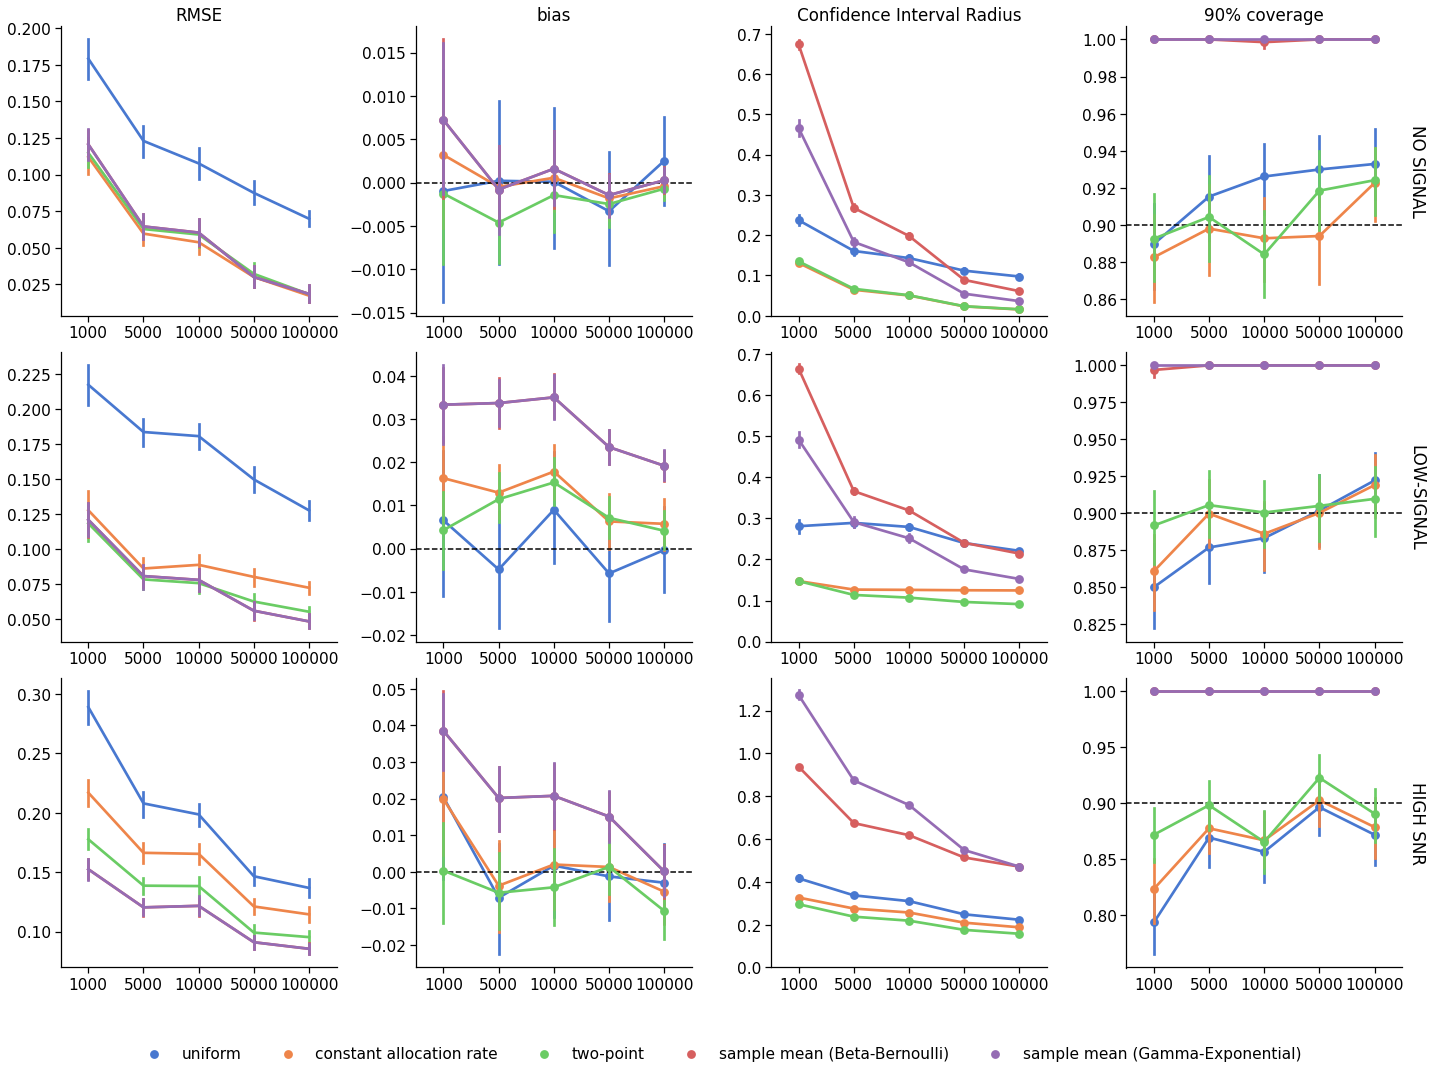

In [133]:
g = sns.catplot(x="T",
                y="value",
                hue='method',
                hue_order=hue_order,
                palette=palette,
                col="experiment_policy",
                col_order=col_order,
                row="statistic",
                row_order=['mse', 'CI_width', '90% coverage of t-stat'],
                kind="point",
                sharex=True,
                sharey='row',
                legend=False,
                legend_out=True,
                margin_titles=True,
                data=df_subset)


# plot RMSE of good arm high SNR
for i, col in enumerate(col_order): # good arm, bad arm, bad(any) arm
    g.axes[0, i].clear()
    sns.pointplot(x='T',
                  y="value",
                  hue='method',
                  hue_order=hue_order,
                  palette=palette,
                  ax=g.axes[0, i],
                  data=df_subset.query(f"statistic=='mse' & experiment_policy == @col"),
                  estimator=lambda x: np.sqrt(np.mean(x)))
    g.axes[0, i].get_legend().remove()
    g.axes[0, i].set_xlabel("")
    g.axes[0, i].set_ylabel("")


# Add row and column names
g.row_names = ['RMSE', 'Confidence Interval Radius', '90% coverage of t-stat']
g.col_names = ['GOOD ARM: HIGH SIGNAL', 'BAD ARM: HIGH SIGNAL', 'NO SIGNAL']


for ax in g.axes.flat:
    plt.setp(ax.texts, text="")

g.set_titles(row_template="{row_name}", col_template="{col_name}")

# rmse
for ax in g.axes[0, :]:
    ax.axhline(0., color="black", linestyle='--')

# ci radius
for ax in g.axes[1, :]:
    ax.axhline(0., color="black", linestyle='--')

# coverage
for ax in g.axes[2, :]:
    ax.axhline(.9, color="black", linestyle='--')

# Add legend
handles, labels = g._legend_data.values(), g._legend_data.keys()
g.fig.legend(labels=['W-decorrelation', 'Two-point allocation'],
             handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.0))

g.set_xlabels("Experiment length")
g.set_ylabels("")

g.fig.tight_layout()
g.fig.subplots_adjust(bottom=0.1)
g.fig.savefig(f'figures/wdecorr.pdf', bbox_inches='tight')

----

## Evaluation of $\lambda$ allocation rates

In [9]:
data_lambda['T'].nunique() == 1
Tmax = data_lambda['T'].max()

g = sns.relplot(x="time",
                y="value",
                col="dgp",
                col_order=[f'nosignal', f'lowSNR', f'highSNR'],
                kind="line",
                row='policy',
                row_order=[2, 0],
                facet_kws=dict(
                    sharex=False,
                    sharey=False),
                legend=False,
                ci=None,
                data=data_lambda)

g.col_names = ['NO SIGNAL', 'LOW SIGNAL', 'HIGH SIGNAL']
g.row_names = ['GOOD ARM', 'BAD ARM']


for ax in g.axes.flat:
    plt.setp(ax.texts, text="")
    ax.set_yscale('log')
    xticks = ax.get_xticks()
    ax.set_xticks([0, xticks[len(xticks)//2], xticks[-1]])
    ax.axhline(1.0, color="black", linestyle='--')
    ax.set_xticklabels([0, Tmax//2, Tmax])
g.set_titles(row_template="{row_name}", col_template="{col_name}")

g.set_xlabels("")
g.set_ylabels("")

g.fig.tight_layout()
g.fig.savefig(f'figures/lambdas.pdf', bbox_inches='tight')